In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import warnings

# Pre - Procesamiento

In [126]:
csv_files = [f for f in os.listdir('..') if f.endswith('.csv')]
print("Archivos CSV disponibles:")
for file in csv_files:
    print(f"- {file}")

Archivos CSV disponibles:
- Aquifer_Auser.csv
- Aquifer_Doganella.csv
- Aquifer_Luco.csv
- Aquifer_Petrignano.csv
- Lake_Bilancino.csv
- River_Arno.csv
- Water_Spring_Amiata.csv
- Water_Spring_Lupa.csv
- Water_Spring_Madonna_di_Canneto.csv


In [127]:
for file in csv_files:
    print(f"\n--- Análisis de {file} ---")
    temp_df = pd.read_csv(f'../{file}')
    print(f"Dimensiones: {temp_df.shape}")
    print(f"Columnas: {temp_df.columns.tolist()}")
    print(f"Primeras filas:")
    print(temp_df.head(3))
    print(f"Tipos de datos:")
    print(temp_df.dtypes)


--- Análisis de Aquifer_Auser.csv ---
Dimensiones: (8154, 27)
Columnas: ['Date', 'Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Croce_Arcana', 'Rainfall_Tereglio_Coreglia_Antelminelli', 'Rainfall_Fabbriche_di_Vallico', 'Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC', 'Temperature_Orentano', 'Temperature_Monte_Serra', 'Temperature_Ponte_a_Moriano', 'Temperature_Lucca_Orto_Botanico', 'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL', 'Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione']
Primeras filas:
         Date  Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
0  05/03/1998                 NaN                  NaN                   NaN   
1  06/03/1998                 NaN                  NaN                   NaN   
2  07/03/1998   

In [128]:
for file in csv_files:
    temp_df = pd.read_csv(f'../{file}')
    
    
    tiene_fecha = any('date' in col.lower() or 'time' in col.lower() or 'day' in col.lower() 
                     or 'month' in col.lower() or 'year' in col.lower() for col in temp_df.columns)
    
    if 'aquifer' in file.lower() or any('aquifer' in col.lower() for col in temp_df.columns):
        archivos_por_categoria['acuifero'].append((file, tiene_fecha))
    elif 'spring' in file.lower() or any('spring' in col.lower() for col in temp_df.columns):
        archivos_por_categoria['manantial'].append((file, tiene_fecha))
    elif 'river' in file.lower() or any('river' in col.lower() for col in temp_df.columns):
        archivos_por_categoria['rio'].append((file, tiene_fecha))
    elif 'lake' in file.lower() or any('lake' in col.lower() for col in temp_df.columns):
        archivos_por_categoria['lago'].append((file, tiene_fecha))
    else:
        
        columnas = ' '.join(temp_df.columns).lower()
        if 'aquifer' in columnas or 'groundwater' in columnas:
            archivos_por_categoria['acuifero'].append((file, tiene_fecha))
        elif 'spring' in columnas:
            archivos_por_categoria['manantial'].append((file, tiene_fecha))
        elif 'river' in columnas or 'flow' in columnas:
            archivos_por_categoria['rio'].append((file, tiene_fecha))
        elif 'lake' in columnas:
            archivos_por_categoria['lago'].append((file, tiene_fecha))

In [129]:
for categoria, archivos in archivos_por_categoria.items():
    print(f"\nArchivos recomendados para {categoria.upper()}:")
    if archivos:
        for archivo, tiene_fecha in archivos:
            estado = "✔ Contiene columnas de fecha/tiempo" if tiene_fecha else "⚠ No se detectaron columnas de fecha/tiempo"
            print(f"- {archivo} ({estado})")
    else:
        print("- No se encontraron archivos específicos para esta categoría")



Archivos recomendados para ACUIFERO:
- Aquifer_Auser.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Doganella.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Luco.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Petrignano.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Auser.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Doganella.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Luco.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Petrignano.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Auser.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Doganella.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Luco.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Petrignano.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Auser.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Doganella.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Luco.csv (✔ Contiene columnas de fecha/tiempo)
- Aquifer_Petrignano.csv (✔ Contiene columnas de fecha/tiempo)
- 

# Desarrollo

In [130]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)

In [131]:
data_dict = {
    'acuifero': [],
    'manantial': [],
    'rio': [],
    'lago': []
}

In [132]:
def cat_archivo(filename, df):
    if 'aquifer' in filename.lower() or any('aquifer' in col.lower() for col in df.columns):
        return 'acuifero'
    elif 'spring' in filename.lower() or any('spring' in col.lower() for col in df.columns):
        return 'manantial'
    elif 'river' in filename.lower() or any('river' in col.lower() for col in df.columns):
        return 'rio'
    elif 'lake' in filename.lower() or any('lake' in col.lower() for col in df.columns):
        return 'lago'
    else:
        
        columnas = ' '.join(df.columns).lower()
        if 'aquifer' in columnas or 'groundwater' in columnas:
            return 'acuifero'
        elif 'spring' in columnas:
            return 'manantial'
        elif 'river' in columnas or 'flow' in columnas:
            return 'rio'
        elif 'lake' in columnas:
            return 'lago'
        return None

In [133]:
for file in csv_files:
    df = pd.read_csv(f'../{file}')
    categoria = cat_archivo(file, df)
    if categoria:
        data_dict[categoria].append((file, df))
        print(f"Archivo '{file}' categorizado como: {categoria}")

Archivo 'Aquifer_Auser.csv' categorizado como: acuifero
Archivo 'Aquifer_Doganella.csv' categorizado como: acuifero
Archivo 'Aquifer_Luco.csv' categorizado como: acuifero
Archivo 'Aquifer_Petrignano.csv' categorizado como: acuifero
Archivo 'Lake_Bilancino.csv' categorizado como: lago
Archivo 'River_Arno.csv' categorizado como: rio
Archivo 'Water_Spring_Amiata.csv' categorizado como: manantial
Archivo 'Water_Spring_Lupa.csv' categorizado como: manantial
Archivo 'Water_Spring_Madonna_di_Canneto.csv' categorizado como: manantial


## 2. Funciones de Preprocesamiento

In [134]:
def ident_date(df):
    date_cols = [col for col in df.columns if any(term in col.lower() for term in 
                ['date', 'time', 'day', 'month', 'year', 'fecha', 'tiempo', 'día', 'mes', 'año'])]
    return date_cols[0] if date_cols else None

In [135]:
def ident_objetive(df):
    water_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['water', 'volume', 'flow', 'level', 'agua', 'volumen', 'flujo', 'nivel'])]
    return water_cols[0] if water_cols else None

In [136]:
def prep_temp_series(df, col_fecha=None, col_objetivo=None):
    
    if col_fecha is None:
        col_fecha = identificar_columna_fecha(df)
    if col_objetivo is None:
        col_objetivo = identificar_columna_objetivo(df)
    
    if col_fecha and col_objetivo:
        
        if not pd.api.types.is_datetime64_any_dtype(df[col_fecha]):
            df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
        
        
        dfTs = df.set_index(col_fecha)[[col_objetivo]]
        
       
        dfTs = dfTs.sort_index()
        
        
        dfTs = dfTs[~dfTs.index.duplicated(keep='first')]
        
        return dfTs
    else:
        print("No se pudieron identificar columnas de fecha u objetivo")
        return None

# 3. Modelado y analisis por categorias

In [ ]:
def identificar_columna_fecha(df):
    
    date_cols = [col for col in df.columns if any(term in col.lower() for term in 
                ['date', 'time', 'day', 'month', 'year', 'fecha', 'tiempo', 'día', 'mes', 'año'])]
    return date_cols[0] if date_cols else None

def identificar_columna_objetivo(df):
   
    water_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['water', 'volume', 'flow', 'level', 'agua', 'volumen', 'flujo', 'nivel'])]
    return water_cols[0] if water_cols else None

In [147]:
def prep_cat_data(categoria, data_list):
    
    print(f"\n=== PREPARACIÓN DE DATOS PARA {categoria.upper()} ===")
    
    if not data_list:
        print(f"No hay datos disponibles para {categoria}")
        return None, None, None
    
    
    filename, df = data_list[0]
    print(f"Utilizando archivo: {filename}")
    
    
    col_fecha = identificar_columna_fecha(df)
    col_objetivo = identificar_columna_objetivo(df)
    
    if not col_fecha or not col_objetivo:
        print("No se pudieron identificar columnas necesarias")
        return None, None, None
    
    print(f"Columna de fecha: {col_fecha}")
    print(f"Columna objetivo: {col_objetivo}")
    
    
    dfTs = prep_temp_series(df, col_fecha, col_objetivo)
    
    if dfTs is None or dfTs.empty:
        print("No se pudo preparar la serie temporal")
        return None, None, None
    
    return dfTs, col_fecha, col_objetivo

In [139]:
def visualizar_serie_temporal(df_ts, categoria, col_objetivo):
    
    plt.figure(figsize=(14, 7))
    plt.plot(dfTs)
    plt.title(f'Serie Temporal para {categoria.capitalize()} - {col_objetivo}')
    plt.xlabel('Fecha')
    plt.ylabel(col_objetivo)
    plt.tight_layout()
    plt.show()

In [140]:
def descom(df_ts):
    
    try:
       
        freq = pd.infer_freq(df_ts.index)
        if not freq:
            
            if len(df_ts) > 365:
                freq = 'D'  
            else:
                freq = 'M'  
        
        
        decomposition = seasonal_decompose(df_ts, model='additive', period=12 if freq == 'M' else 30)
        
       
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
        decomposition.observed.plot(ax=ax1)
        ax1.set_title('Observado')
        decomposition.trend.plot(ax=ax2)
        ax2.set_title('Tendencia')
        decomposition.seasonal.plot(ax=ax3)
        ax3.set_title('Estacionalidad')
        decomposition.resid.plot(ax=ax4)
        ax4.set_title('Residuos')
        plt.tight_layout()
        plt.show()
        return decomposition
    except Exception as e:
        print(f"No se pudo realizar la descomposición: {e}")
        return None

In [141]:
def veri_estacionariedad(df_ts):
    
    result = adfuller(df_ts.dropna())
    print('Prueba ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    if result[1] > 0.05:
        print("La serie no es estacionaria, aplicando diferenciación")
        df_diff = df_ts.diff().dropna()
    else:
        print("La serie es estacionaria")
        df_diff = df_ts
    
    return df_diff

In [142]:
def visualizardor_acf_pacf(df_diff):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    plot_acf(df_diff, ax=ax1)
    plot_pacf(df_diff, ax=ax2)
    plt.tight_layout()
    plt.show()

In [143]:
def arima(dfTs, categoria):
    train_size = int(len(dfTs) * 0.8)
    train, test = dfTs.iloc[:train_size], dfTs.iloc[train_size:]
    
    try:
       
        p, d, q = 1, 1, 1
        
        
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        
        print(model_fit.summary())
        
        predictions = model_fit.forecast(steps=len(test))
        
        
        plt.figure(figsize=(14, 7))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test, label='Prueba')
        plt.plot(test.index, predictions, label='Predicciones', color='red')
        plt.title(f'Predicciones ARIMA para {categoria.capitalize()}')
        plt.legend()
        plt.show()
        
        
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        
        return model_fit, predictions, test
    except Exception as e:
        print(f"Error al ajustar el modelo ARIMA: {e}")
        return None, None, None

In [144]:
def analizar_categoria(categoria, data_list):
   
    print(f"\n=== ANÁLISIS COMPLETO PARA {categoria.upper()} ===")
    
    
    dfTs, col_fecha, col_objetivo = preparar_datos_categoria(categoria, data_list)
    if dfTs is None:
        return None
    
    #
    print("\nPaso 2: Visualización de la serie temporal")
    visualizardor_acf_pacf(dfTs, categoria, col_objetivo)
    
    
    print("\nPaso 3: Descomposición de la serie temporal")
    descom = realizar_descomposicion(dfTs)
    
    
    print("\nPaso 4: Verificación de estacionariedad")
    df_diff = veri_estacionariedad(dfTs)
    
    
    print("\nPaso 5: Visualización de ACF y PACF")
    visualizar_acf_pacf(df_diff)
    
    
    print("\nPaso 6: Ajuste de modelo ARIMA")
    model_fit, predictions, test = arima(dfTs, categoria)
    
    return model_fit


=== PREPARACIÓN DE DATOS PARA ACUIFERO ===
Utilizando archivo: Aquifer_Auser.csv
Columna de fecha: Date
Columna objetivo: Depth_to_Groundwater_LT2


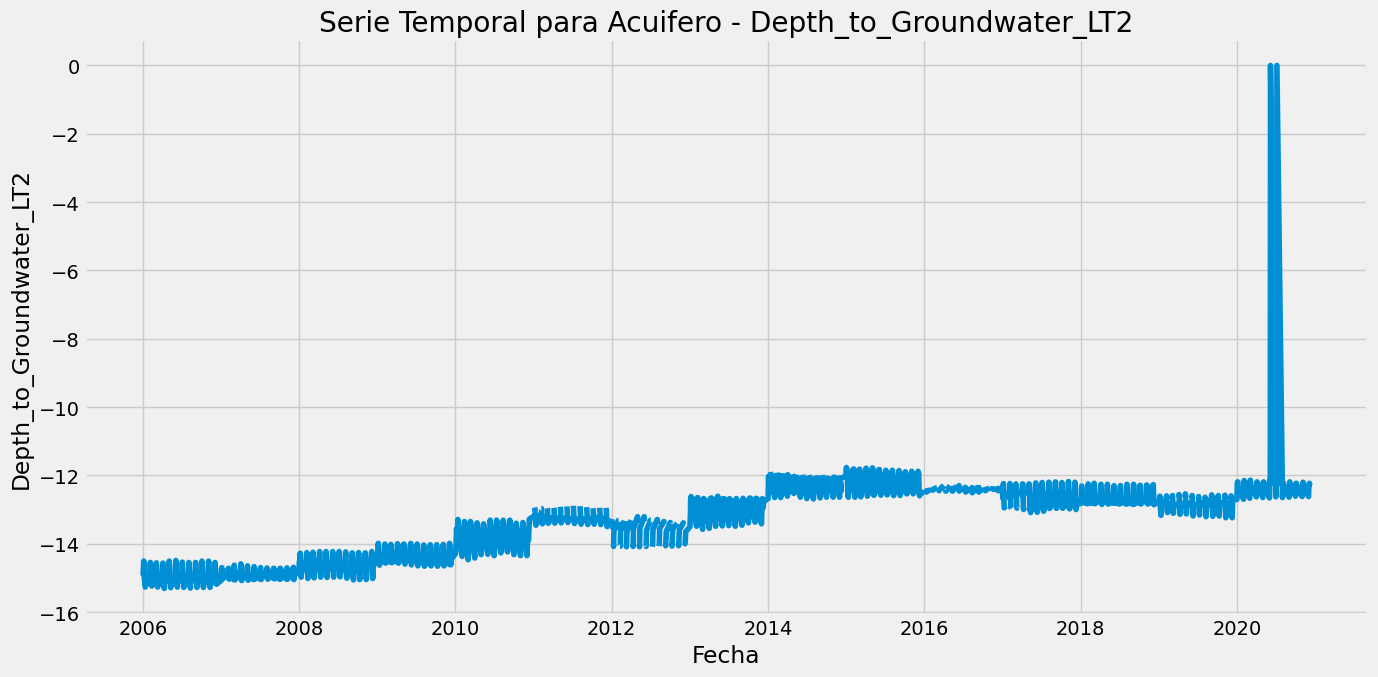

No se pudo realizar la descomposición: This function does not handle missing values
Prueba ADF Statistic: -1.322753
p-value: 0.618700
La serie no es estacionaria, aplicando diferenciación


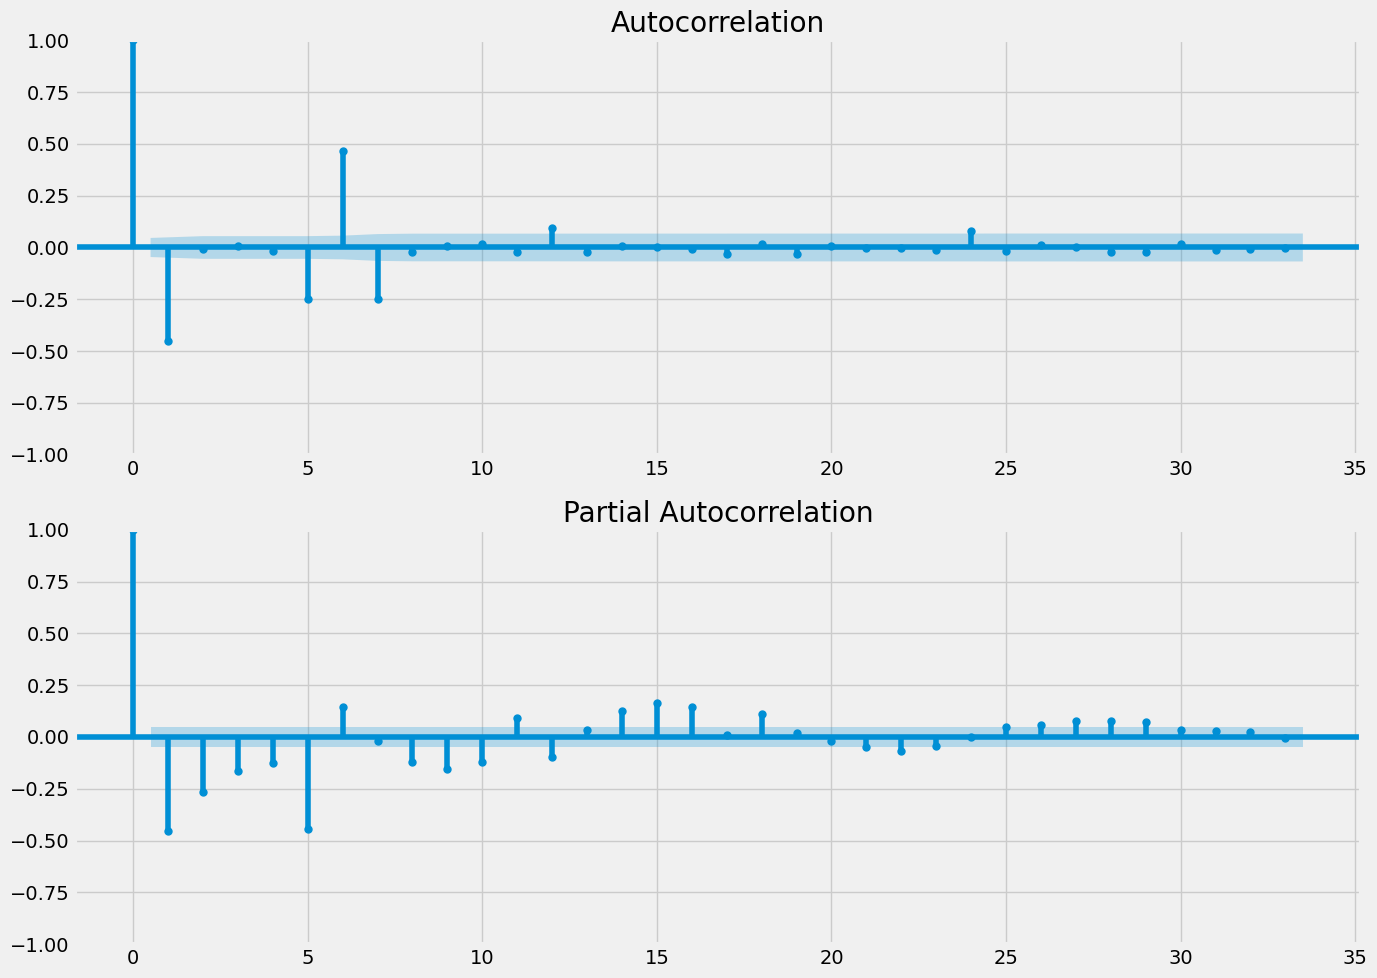

                                  SARIMAX Results                                   
Dep. Variable:     Depth_to_Groundwater_LT2   No. Observations:                 2570
Model:                       ARIMA(1, 1, 1)   Log Likelihood                 163.965
Date:                      Fri, 14 Mar 2025   AIC                           -321.931
Time:                              15:19:39   BIC                           -304.377
Sample:                                   0   HQIC                          -315.567
                                     - 2570                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0009     18.633  -4.91e-05      1.000     -36.520      36.518
ma.L1         -0.0010     18.635  -5.17e-05      1.000     -36.524      36.522
sigm

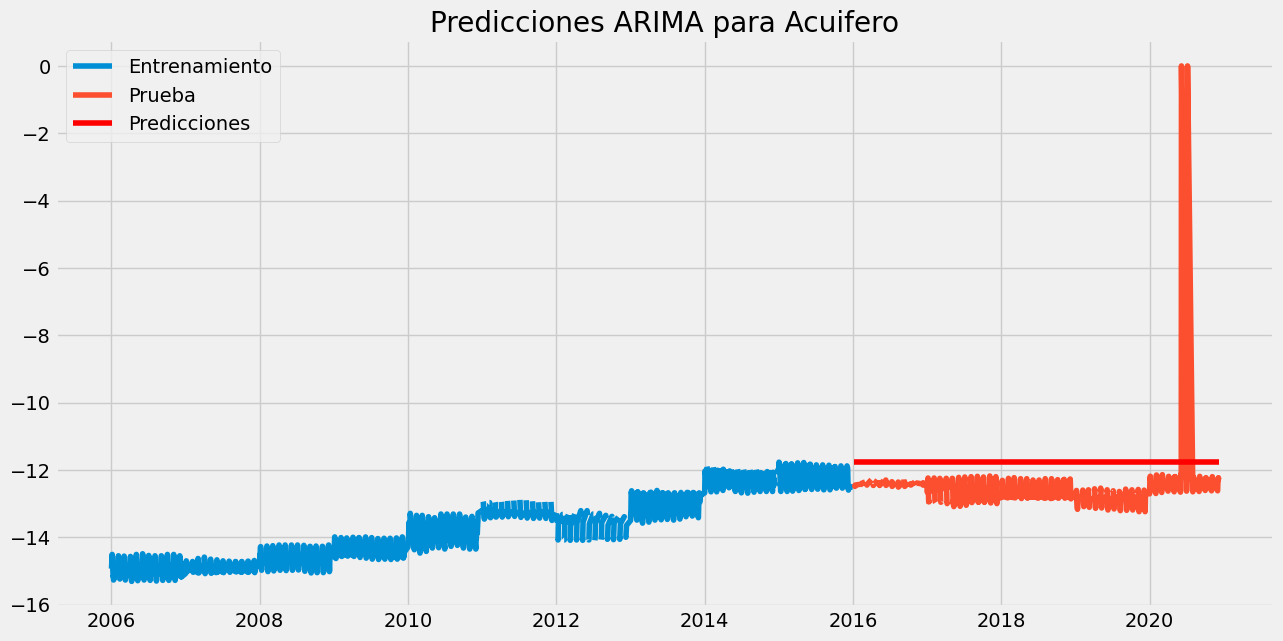

Error al ajustar el modelo ARIMA: Input contains NaN.


In [148]:
categoria = 'acuifero'
data_list = data_dict[categoria]
dfTs, col_fecha, col_objetivo = prep_cat_data(categoria, data_list)

visualizar_serie_temporal(dfTs, categoria, col_objetivo)


descom = realizar_descomposicion(dfTs)


df_diff = veri_estacionariedad(dfTs)


visualizardor_acf_pacf(df_diff)

model_fit, predictions, test = arima(dfTs, categoria)